In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn import metrics

from PIL import Image

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks

%matplotlib inline

In [ ]:
csv_5fam = "/content/gdrive/MyDrive/Colab Notebooks/reduced_dataset_5_families.csv"
df = pd.read_csv(csv_5fam)

folderpath = "/content/gdrive/MyDrive/images_mushroom/"
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

df.head()

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/28.jpg,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/86.jpg,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/87.jpg,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/126.jpg,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/128.jpg,1


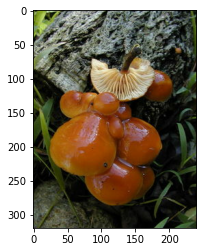

In [ ]:
# Just to run a simple test:

im = tf.io.read_file(df['filepath'].iloc[37])
# Décoder l'information en un tensorflow RGB (3 channels).
im = tf.image.decode_jpeg(im, channels=3)

plt.imshow(im);

In [ ]:
#X_train_path, X_test_path, y_train, y_test = train_test_split(df['filepath'], df['label'], test_size=0.2, random_state=42)

#X_test = []
#for filepath in tqdm(X_test_path):
#    # Lecture du fichier
#    im = tf.io.read_file(filepath)
#    # On décode le fichier
#    im = tf.image.decode_jpeg(im, channels=3)
#    # Redimensionnement
#    im = tf.image.resize(im, size=(256, 256))
#    X_test.append([im])
    
#X_test = tf.concat(X_test, axis=0)

In [ ]:
#@tf.function
#def load_image(filepath, resize=(256, 256)):
#    im = tf.io.read_file(filepath)
#    im = tf.image.decode_jpeg(im, channels=3)
#    im = tf.image.resize(im, resize)
#    return im

#dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
#dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(64)

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

train_data_generator = ImageDataGenerator(rotation_range=5,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.05,
                                          zoom_range = 1.1)

test_data_generator = ImageDataGenerator()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')


efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 5, activation = 'softmax'))

#model.summary()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.
27025408/27018416 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/test_model_checkpoint_save/model_effnetB1_3_20210623.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 20,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

## custom warning during training :
# /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a
# config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
# category=CustomMaskWarning)

Epoch 1/30
428/428 [==============================] - 4491s 10s/step - loss: 1.3792 - accuracy: 0.4146 - val_loss: 1.4306 - val_accuracy: 0.4980


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 2/30
428/428 [==============================] - 305s 712ms/step - loss: 1.2735 - accuracy: 0.4755 - val_loss: 1.0370 - val_accuracy: 0.5879


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 3/30
428/428 [==============================] - 432s 1s/step - loss: 1.2202 - accuracy: 0.5063 - val_loss: 1.0779 - val_accuracy: 0.5730
Epoch 4/30
428/428 [==============================] - 314s 732ms/step - loss: 1.1700 - accuracy: 0.5259 - val_loss: 0.9613 - val_accuracy: 0.6268


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 5/30
428/428 [==============================] - 328s 766ms/step - loss: 1.1407 - accuracy: 0.5385 - val_loss: 1.0289 - val_accuracy: 0.6203
Epoch 6/30
428/428 [==============================] - 383s 894ms/step - loss: 1.1117 - accuracy: 0.5549 - val_loss: 0.9774 - val_accuracy: 0.6124
Epoch 7/30
428/428 [==============================] - 412s 961ms/step - loss: 1.0754 - accuracy: 0.5699 - val_loss: 1.0387 - val_accuracy: 0.6387

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/30
428/428 [==============================] - 449s 1s/step - loss: 0.9559 - accuracy: 0.6191 - val_loss: 0.7559 - val_accuracy: 0.7097


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 9/30
428/428 [==============================] - 448s 1s/step - loss: 0.9062 - accuracy: 0.6416 - val_loss: 0.7213 - val_accuracy: 0.7269


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 10/30
428/428 [==============================] - 309s 720ms/step - loss: 0.8754 - accuracy: 0.6535 - val_loss: 0.7026 - val_accuracy: 0.7334


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 11/30
428/428 [==============================] - 279s 650ms/step - loss: 0.8594 - accuracy: 0.6616 - val_loss: 0.6828 - val_accuracy: 0.7427


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 12/30
428/428 [==============================] - 279s 651ms/step - loss: 0.8368 - accuracy: 0.6702 - val_loss: 0.6800 - val_accuracy: 0.7494


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 13/30
428/428 [==============================] - 280s 654ms/step - loss: 0.8139 - accuracy: 0.6743 - val_loss: 0.6700 - val_accuracy: 0.7520


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 14/30
428/428 [==============================] - 279s 652ms/step - loss: 0.8096 - accuracy: 0.6766 - val_loss: 0.6733 - val_accuracy: 0.7462
Epoch 15/30
428/428 [==============================] - 279s 652ms/step - loss: 0.7973 - accuracy: 0.6816 - val_loss: 0.6573 - val_accuracy: 0.7526


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 16/30
428/428 [==============================] - 279s 650ms/step - loss: 0.7660 - accuracy: 0.6968 - val_loss: 0.6810 - val_accuracy: 0.7564
Epoch 17/30
428/428 [==============================] - 278s 649ms/step - loss: 0.7685 - accuracy: 0.6962 - val_loss: 0.6381 - val_accuracy: 0.7640


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet/assets
Epoch 18/30
428/428 [==============================] - 279s 651ms/step - loss: 0.7605 - accuracy: 0.7026 - val_loss: 0.6599 - val_accuracy: 0.7596
Epoch 19/30
428/428 [==============================] - 279s 652ms/step - loss: 0.7367 - accuracy: 0.7097 - val_loss: 0.6540 - val_accuracy: 0.7623
Epoch 20/30
428/428 [==============================] - 280s 653ms/step - loss: 0.7270 - accuracy: 0.7115 - val_loss: 0.6757 - val_accuracy: 0.7518

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/30
428/428 [==============================] - 280s 653ms/step - loss: 0.7111 - accuracy: 0.7194 - val_loss: 0.6525 - val_accuracy: 0.7672
Epoch 22/30
269/428 [=================>............] - ETA: 1:38 - loss: 0.7130 - accuracy: 0.7165

NameError: ignored

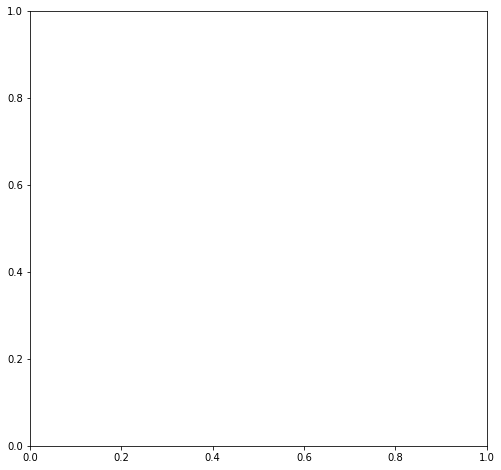

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(history.history['loss'])), history.history['loss'], label = "training")
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(history.history['acc'])), history.history['acc'], label = "training")
plt.plot(range(len(history.history['val_acc'])), history.history['val_acc'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

In [ ]:
### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/model_effnetB1_GPU_colab_20210622.h5"
#
##
###


new_model.save(save_name)

## found on stackoverflow
#loaded_model = create_model()
#loaded_model.load_weights(filepath)
#y_pred = loaded.model.<predict_method>(test_set,verbose=<val>)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
